In [1]:
import torch
from datasets import load_from_disk
from torch.utils.data import DataLoader
from diffusers import AutoencoderKL
from tqdm.notebook import tqdm
from torch.optim.lr_scheduler import OneCycleLR
from torch.amp import autocast, GradScaler
from torch.nn.utils import clip_grad_norm_
import numpy as np
from rf import RF
from accelerate import Accelerator
from transformer.microdit import MicroDiT
from transformer.utils import strings_to_tensor, random_mask, remove_masked_patches, add_masked_patches
import matplotlib.pyplot as plt

In [2]:
bs = 16
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# Run the precompute_latents.ipynb notebook to download the dataset and save it to the datasets/CelebA-attrs-latents folder

train_ds = load_from_disk("../../datasets/CelebA-attrs-latents/train")
# validation_ds = load_from_disk("../../datasets/CelebA-attrs-latents/validation")
# test_ds = load_from_disk("../../datasets/CelebA-attrs-latents/test")

Loading dataset from disk:   0%|          | 0/153 [00:00<?, ?it/s]

In [4]:
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
# validation_dl = DataLoader(validation_ds, batch_size=bs, shuffle=True)
# test_dl = DataLoader(test_ds, batch_size=bs, shuffle=True)  

In [5]:
torch.set_printoptions(precision=2)

rand_patches = torch.randn(1, 4, 10)
print("Rand Patches: ", rand_patches)
mask = random_mask(1, 4, 4, 2, 0.5)

masked_patches = remove_masked_patches(rand_patches, mask)

print("Mask: ", mask)
print("Masked Patches: ", masked_patches)

full_patches = add_masked_patches(masked_patches, mask)
print("Full Patches: ", full_patches)



Rand Patches:  tensor([[[ 0.81, -0.03,  0.62, -2.06, -0.16,  0.37,  0.35, -1.04, -0.26, -0.51],
         [-0.60,  1.49,  1.21,  0.16,  1.27, -0.16,  0.36, -0.48,  0.11, -1.65],
         [-0.96,  0.54,  0.33,  0.87,  0.46, -1.86,  0.74, -1.26,  1.50,  1.19],
         [ 0.79, -0.97, -0.03, -1.42, -0.92, -0.89, -0.09, -0.16, -1.50, -0.71]]])
Mask:  tensor([[1., 0., 0., 1.]])
Masked Patches:  tensor([[[ 0.81, -0.03,  0.62, -2.06, -0.16,  0.37,  0.35, -1.04, -0.26, -0.51],
         [ 0.79, -0.97, -0.03, -1.42, -0.92, -0.89, -0.09, -0.16, -1.50, -0.71]]])
Full Patches:  tensor([[[ 0.81, -0.03,  0.62, -2.06, -0.16,  0.37,  0.35, -1.04, -0.26, -0.51],
         [ 0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00],
         [ 0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00],
         [ 0.79, -0.97, -0.03, -1.42, -0.92, -0.89, -0.09, -0.16, -1.50, -0.71]]])


In [6]:
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", cache_dir="../../models/vae")
# vae = vae.to(device)

In [7]:
input_dim = 4  # 4 channels in latent space
patch_size = 1 
embed_dim = 768
num_layers = 12
num_heads = 12
mlp_dim = embed_dim * 4
class_label_dim = 40  # 40 attributes in CelebA dataset
patch_mixer_layers = 1

epochs = 1
mask_ratio = 0.75

In [8]:
model = MicroDiT(input_dim, patch_size, embed_dim, num_layers, num_heads, mlp_dim, class_label_dim, patch_mixer_layers=patch_mixer_layers)

rf = RF(model, ln=True)
# model = model.to(device)

In [9]:
# Print model parameters count
print(sum(p.numel() for p in model.parameters()))

602188548


In [10]:
# Attempt overfitting to just one batch of images first
# from torch.utils.data import Subset
# subset = Subset(train_ds, range(9))
# train_dl = DataLoader(subset, batch_size=9, shuffle=False, pin_memory=True, pin_memory_device=device)

# latents_mean = train_ds["latents"].mean()
# latents_std = train_ds["latents"].std()




# latents_mean, latents_std

In [11]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)

# Calculate the total number of steps in your single epoch
total_steps = len(train_dl) * epochs

# Add the OneCycleLR scheduler
scheduler = OneCycleLR(optimizer, max_lr=5e-4, total_steps=total_steps)

In [12]:
len(train_dl) * bs


162784

In [13]:
accelerator = Accelerator(mixed_precision="fp16")

model, rf, optimizer, train_dl, scheduler, vae = accelerator.prepare(
    model, rf, optimizer, train_dl, scheduler, vae
)

d:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\accelerate\accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [14]:
latents_mean = torch.tensor(-0.57).to(accelerator.device)
latents_std = torch.tensor(6.91).to(accelerator.device)

latents_mean, latents_std

(tensor(-0.57, device='cuda:0'), tensor(6.91, device='cuda:0'))

In [15]:
def train_model(model, rf, train_dl, epochs, mask_ratio, latents_mean, latents_std, patch_size, accelerator, optimizer, lr_scheduler, max_steps=None):
    scaler = GradScaler(device=accelerator.device)

    loss_history = []

    i = 0
    if max_steps is None: 
        pbar = tqdm(total=len(train_dl) * epochs)
    else:
        pbar = tqdm(total=max_steps)
    for epoch in range(epochs):
        epoch_loss = 0.0

        for batch_idx, batch in enumerate(train_dl):
            if max_steps is not None:
                if i >= max_steps:
                    return loss_history
            
            bs = batch["latents"].shape[0]
            image_prompts = strings_to_tensor(batch["prompt_string"]).to(accelerator.device)
            latents = batch["latents"]

            latents = (latents - latents_mean) / latents_std

            mask = random_mask(bs, latents.shape[-2], latents.shape[-1], patch_size, mask_ratio=mask_ratio).to(accelerator.device)
            # masked_noise = noise * mask.unsqueeze(1).view(bs, 1, latents.shape[-2], latents.shape[-1])

            optimizer.zero_grad()

            with autocast(device_type=str(accelerator.device)):
                # pred = model(noised_latents, noise_amt, image_prompts, mask)
                # loss = loss_fn(pred, masked_noise) * 1/(1-mask_ratio)
                loss, _ = rf.forward(latents, image_prompts, mask)
                loss = loss * 1/(1-mask_ratio)

            accelerator.backward(scaler.scale(loss))
            
            # Gradient clipping
            scaler.unscale_(optimizer)
            clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            scaler.step(optimizer)
            scaler.update()
            lr_scheduler.step()

            loss_value = loss.item()
            epoch_loss += loss_value
            loss_history.append(loss_value)

            pbar.set_postfix({'loss': f'{loss_value:.4f}'})
            pbar.update(1)

            i += 1

        # Calculate average loss for the epoch
        avg_loss = epoch_loss / len(train_dl)

        print(f"Epoch {epoch+1} average loss: {avg_loss:.4f}")
    
    return loss_history

In [16]:
max_steps = None

loss_history = train_model(model, rf, train_dl, epochs, mask_ratio, latents_mean, latents_std, patch_size, accelerator, optimizer, scheduler, max_steps=max_steps)

  0%|          | 0/10174 [00:00<?, ?it/s]

d:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\functional.py:5560: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


KeyboardInterrupt: 

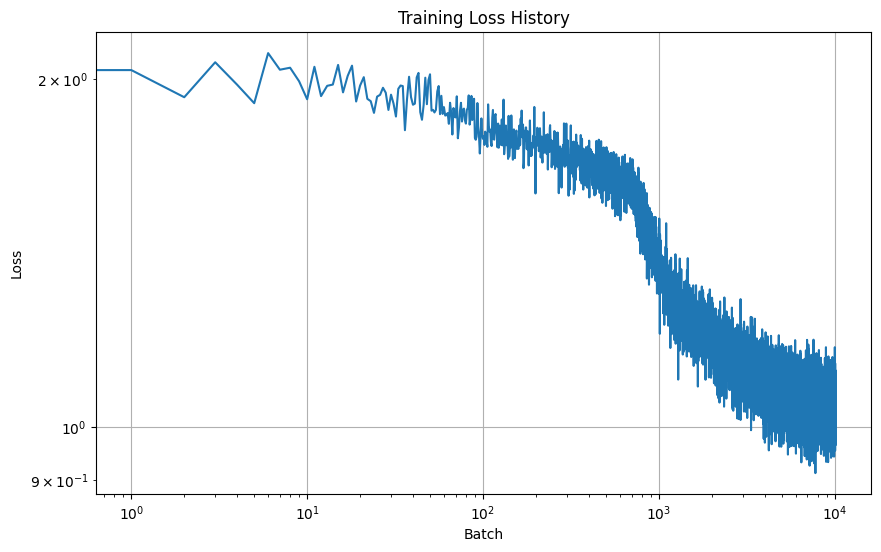

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(loss_history)
plt.xscale('log')  # Set x-axis to log scale
plt.yscale('log')  # Set y-axis to log scale
plt.title('Training Loss History')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [ ]:
finetuning_steps = total_steps // 10
bs = int(bs * (1-mask_ratio) * 0.5)
train_dl = accelerator.prepare(DataLoader(train_ds, batch_size=bs, shuffle=True))
mask_ratio = 0.


scheduler = OneCycleLR(optimizer, max_lr=1e-4, total_steps=finetuning_steps)

loss_history2 = train_model(model, rf, train_dl, epochs, mask_ratio, latents_mean, latents_std, patch_size, accelerator, optimizer, scheduler, max_steps=finetuning_steps)

  0%|          | 0/1017 [00:00<?, ?it/s]

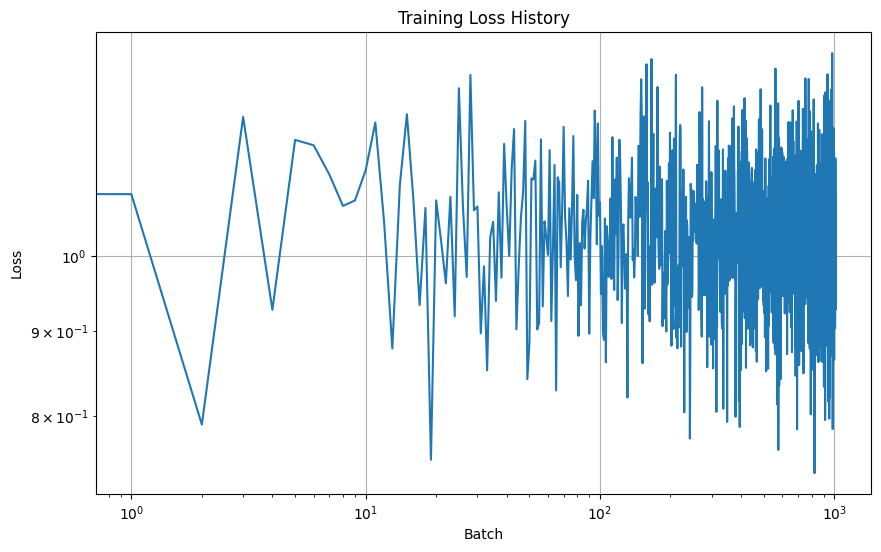

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(loss_history2)
plt.xscale('log')  # Set x-axis to log scale
plt.yscale('log')  # Set y-axis to log scale
plt.title('Training Loss History')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

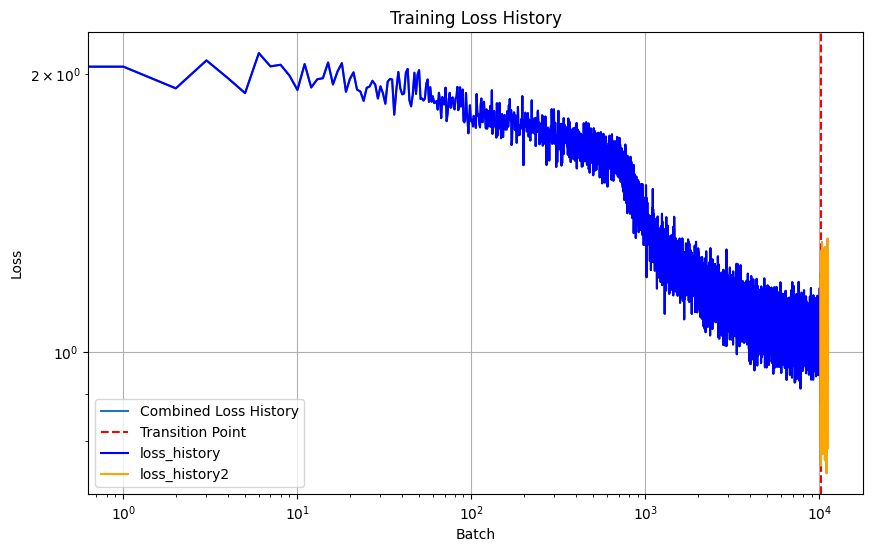

In [ ]:
# Concatenate the loss histories
combined_loss_history = loss_history + loss_history2

# Plot the combined loss history
plt.figure(figsize=(10, 6))
plt.plot(combined_loss_history, label='Combined Loss History')

# Highlight the transition point
transition_point = len(loss_history)
plt.axvline(x=transition_point, color='red', linestyle='--', label='Transition Point')

# Plot the individual loss histories with different colors
plt.plot(range(transition_point), loss_history, label='loss_history', color='blue')
plt.plot(range(transition_point, transition_point + len(loss_history2)), loss_history2, label='loss_history2', color='orange')

plt.xscale('log')  # Set x-axis to log scale
plt.yscale('log')  # Set y-axis to log scale
plt.title('Training Loss History')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
# import os

# # Create models directory if it doesn't exist
# os.makedirs('models/diffusion', exist_ok=True)

# # Save the model
# torch.save(model.state_dict(), 'models/diffusion/microdiffusion_model.pth')

# print("Model saved successfully.")

In [ ]:
# # Load the saved model
# model_path = 'models/diffusion/microdiffusion_model.pth'
# model.load_state_dict(torch.load(model_path))
# model.eval()  # Set the model to evaluation mode

# print("Model loaded successfully.")

In [ ]:
# def sample(model, class_labels, mask, bs: int = 9, steps: int = 100):
#     x = torch.randn(bs, 4, 27, 22).to(device)

#     pred_weight = 2/steps
#     x_weight = 1 - pred_weight

#     for step in range(steps):
#         pred_weight = step/steps
#         x_weight = 1 - pred_weight

#         timestep = ((steps - step) * 1000 / steps) * torch.ones(bs, device=device)
#         pred = model.forward(x, timestep, class_labels, mask)

#         x = x * x_weight + pred * pred_weight
#     return pred

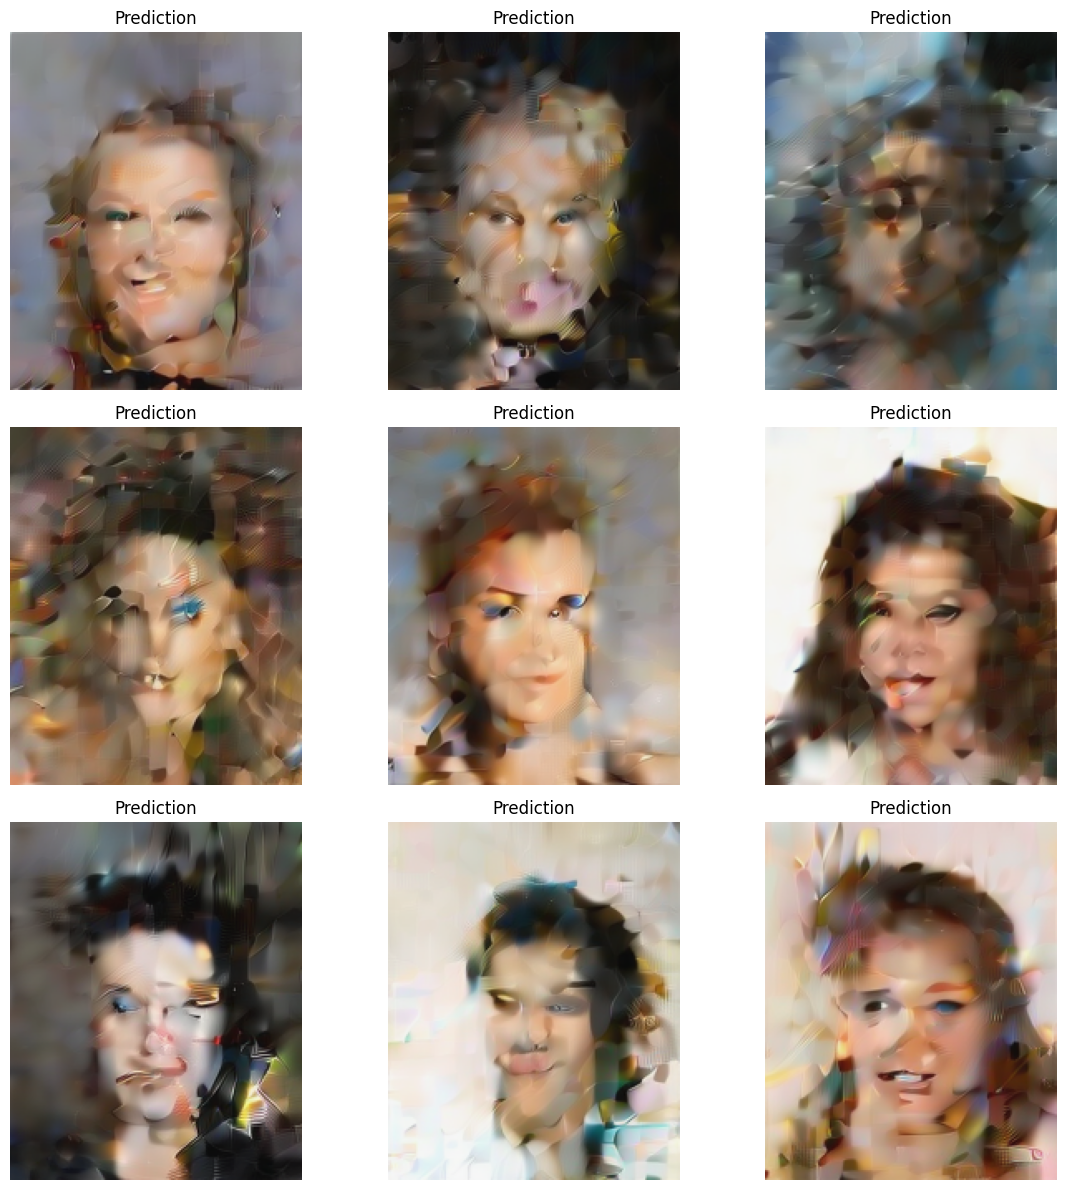

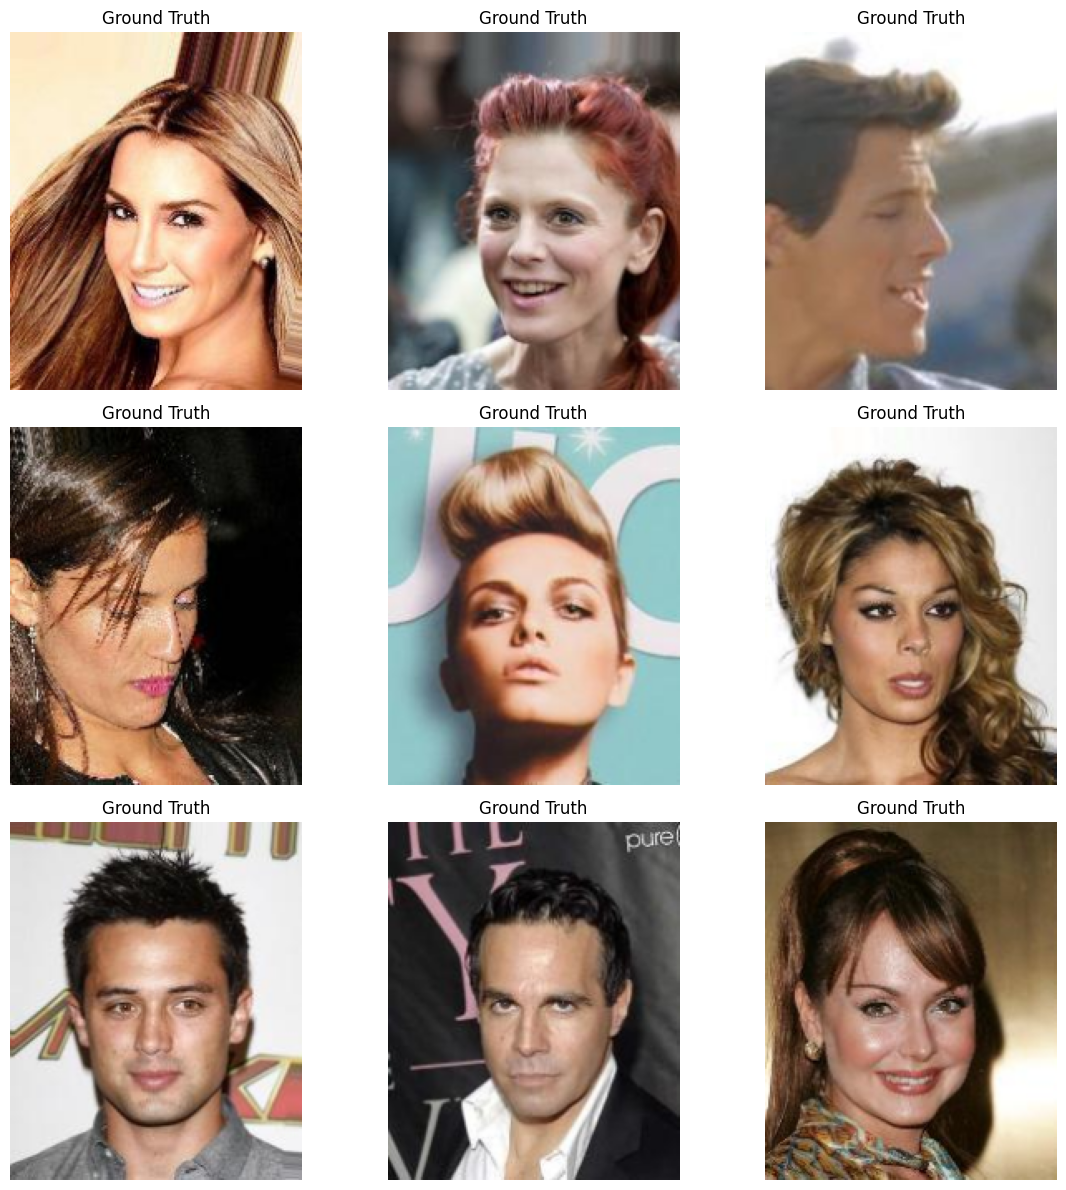

In [ ]:
mask = random_mask(9, 27, 22, patch_size, 0.)
noise = torch.randn(9, 4, 27, 22).to(device)
noise_level = torch.ones(9).to(device)

image_prompts = train_ds[0:9]["prompt_string"]
image_prompts = strings_to_tensor(image_prompts).to(device)

with torch.inference_mode():
    with autocast(device_type=str(accelerator.device)):
        # pred = model.forward(noise, noise_level*1000, image_prompts, mask)
        # pred = sample(model, image_prompts, mask, steps=10)
        pred = rf.sample(noise, image_prompts, sample_steps=10)[-1]
        pred = (pred * latents_std) + latents_mean

        pred = vae.decode(pred).sample
        # Change range of pred from x to y to -1 to 1
        min_val = pred.min()
        max_val = pred.max()

        pred = (pred - min_val) / (max_val - min_val)
        pred = 2 * pred - 1


ground_truth = train_ds[0:9]["image"]

with torch.inference_mode():
    pred_cpu = pred.cpu()
    pred_np = pred_cpu.permute(0, 2, 3, 1).numpy()
    pred_np = (pred_np + 1) / 2
    pred_np = (pred_np * 255).astype(np.uint8)  # Convert to uint8

    ground_truth_cpu = ground_truth.cpu()
    ground_truth_np = ground_truth_cpu.permute(0, 2, 3, 1).numpy()
    ground_truth_np = (ground_truth_np + 1) / 2
    ground_truth_np = (ground_truth_np * 255).astype(np.uint8)  # Convert to uint8
    # Create figure for predictions
    fig_pred, axes_pred = plt.subplots(3, 3, figsize=(12, 12))  # 3 rows, 3 columns

    # Plot predictions
    for i, ax in enumerate(axes_pred.flatten()):
        if i < pred_np.shape[0]:
            ax.imshow(pred_np[i])
            ax.set_title('Prediction')
            ax.axis('off')
        else:
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

    # Create figure for ground truth
    fig_gt, axes_gt = plt.subplots(3, 3, figsize=(12, 12))  # 3 rows, 3 columns

    # Plot ground truth
    for i, ax in enumerate(axes_gt.flatten()):
        if i < ground_truth_np.shape[0]:
            ax.imshow(ground_truth_np[i])
            ax.set_title('Ground Truth')
            ax.axis('off')
        else:
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()